In [78]:
# CELL 1: Imports, Configuration, and Seeding
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import optuna
import os
import gc
import random
import warnings

warnings.filterwarnings('ignore')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Global configuration dictionary
# TOP 1% FIX: HORIZON=500. 
# We need a longer horizon to capture moves large enough to cross the spread.
CONFIG = {
    "TRAIN_PATH": "/kaggle/input/fi2010-lob/FI2010_train.csv",
    "TEST_PATH": "/kaggle/input/fi2010-lob/FI2010_test.csv",
    "HORIZON": 500,      # Increased to 500 ticks
    "THRESHOLD": 0.0,    # Set to 0 because "crossing the spread" is the threshold itself
    "TRAIN_SPLIT": 0.8,
    "BATCH": 256,
    "EPOCHS": 15,
    "OPTUNA_TRIALS": 12,
    "OPTUNA_SAMPLE": 20000,
    "SEED": 42
}

def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

seed_all(CONFIG["SEED"])

Using device: cuda


In [79]:
# CELL 2: Model Architectures (DeepLOB_W3, TFCN, MicroTransformer)

# 1. EMA Helper for Model Averaging
class EMA:
    """Calculates and stores the Exponential Moving Average of model parameters."""
    def __init__(self, model, decay=0.995):
        self.model = model
        self.decay = decay
        self.shadow = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.data.clone().detach()

    def update(self):
        for name, p in self.model.named_parameters():
            if p.requires_grad:
                if name not in self.shadow:
                    self.shadow[name] = p.data.clone().detach()
                else:
                    new_average = (1.0 - self.decay) * p.data + self.decay * self.shadow[name]
                    self.shadow[name] = new_average.clone()

    def apply(self):
        for name, p in self.model.named_parameters():
            if p.requires_grad and name in self.shadow:
                p.data.copy_(self.shadow[name])

# 2. DeepLOB_W3 (FIXED: Corrected Kernel Size for (N, 4, 10, 1) input)
class DeepLOB_W3(nn.Module):
    """
    DeepLOB architecture adapted for (B, 4, 10, W) input.
    """
    def __init__(self, nclass=3):
        super().__init__()
        
        # Layer 1: CNN for spatial feature extraction
        # Input shape: (Batch, Channels=4, Height=10, Width=1)
        # We use a (1,1) kernel first to mix the 4 channels (BidP, BidV, AskP, AskV)
        # Alternatively, standard DeepLOB uses (1,2) on specific reshaping, 
        # but here (1,1) is safer and effectively mixes the microstructure features per level.
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=(1, 1), padding=0), 
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
            
            # Now we convolve across the 10 levels (Height)
            nn.Conv2d(16, 16, kernel_size=(4, 1), padding='same'), 
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 16, kernel_size=(4, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
        
        # The output shape will be (B*W, 16, 10, 1)
        # Flattening: 16 * 10 = 160 features per timestep
        self.lstm = nn.LSTM(input_size=16*10, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, nclass)

    def forward(self, x, a=None):
        # x: (B, 4, 10, W)
        B, C, L, W = x.shape
        
        # Reshape to treat W timesteps independently for CNN
        # (B, 4, 10, W) -> (B, W, 4, 10) -> (B*W, 4, 10, 1)
        x_flat = x.permute(0, 3, 1, 2).reshape(B * W, C, L, 1)
        
        # CNN Feature Extraction
        out = self.conv1(x_flat) # (B*W, 16, 10, 1)
        
        # Flatten features per timestep
        out = out.reshape(B, W, -1) # (B, W, 160)
        
        # Temporal processing (LSTM)
        out, _ = self.lstm(out) # (B, W, 64)
        
        # Take the output of the last timestep
        last_out = out[:, -1, :]
        
        return self.fc(last_out)

# 3. TFCN (Temporal Flow Convolutional Network)
class TFCN(nn.Module):
    def __init__(self, nclass=3):
        super().__init__()
        self.pre = nn.Conv2d(4, 32, (1, 1))
        self.tcn = nn.Sequential(
            nn.Conv1d(32, 32, 2, padding=1), nn.ReLU(),
            nn.Conv1d(32, 32, 2, padding=1), nn.ReLU()
        )
        self.fc = None
        self.nclass = nclass

    def _build_fc(self, in_dim, device):
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, self.nclass)
        ).to(device)

    def forward(self, x, a=None):
        z = self.pre(x).mean(dim=2) # (B, 32, W)
        z = self.tcn(z)             # (B, 32, W_new)
        z = z.reshape(z.size(0), -1)
        if self.fc is None:
            self._build_fc(z.size(1), z.device)
        return self.fc(z)

# 4. MicroTransformer
class MicroTransformer(nn.Module):
    def __init__(self, nclass=3, alpha_dim=8):
        super().__init__()
        self.preX = nn.Conv2d(4, 32, (1, 1)) 
        self.preA = nn.Conv1d(alpha_dim, 32, 1) 
        layer = nn.TransformerEncoderLayer(d_model=32, nhead=4, dim_feedforward=64, batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=2)
        self.fc = None
        self.nclass = nclass

    def _build_fc(self, in_dim, device):
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 64), 
            nn.ReLU(),
            nn.Linear(64, self.nclass)
        ).to(device)

    def forward(self, x, a):
        x_emb = self.preX(x).mean(dim=2).permute(0, 2, 1) # (B, W, 32)
        if a is None:
            a_emb = torch.zeros_like(x_emb)
        else:
            a_emb = self.preA(a).permute(0, 2, 1)
        z = x_emb + a_emb
        z = self.tr(z)
        z = z.reshape(z.size(0), -1)
        if self.fc is None:
            self._build_fc(z.size(1), z.device)
        return self.fc(z)

In [80]:
# CELL 3: Data Utilities (Cleaning and Repairing)

def clean_df(df):
    """Removes non-numeric and constant columns."""
    df = df.select_dtypes(include=[np.number])
    df = df.loc[:, ~df.columns.duplicated()]
    # Drop columns with 0 variance (constants)
    df = df.loc[:, df.nunique() > 1]
    # Replace infinite values and NaNs safely
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def repair(df):
    """
    Repairs column structure to ensure it is divisible by 40 
    (10 levels * 4 features: BidP, BidV, AskP, AskV).
    """
    df = df.copy()
    
    # Drop first column if it looks like an index
    if df.shape[1] > 0 and (df.iloc[:, 0].dropna().astype(int).values == np.arange(len(df))).all():
        df = df.iloc[:, 1:]

    # Drop columns to align to a multiple of 40
    rem = df.shape[1] % 40
    if rem > 0:
        # Drop the `rem` columns with the lowest variance (likely noise/timestamps)
        v = df.var().sort_values(ascending=True)
        cols_to_drop = v.index[:rem]
        df = df.drop(columns=cols_to_drop)
    
    W = df.shape[1] // 40
    assert df.shape[1] % 40 == 0, f"Shape {df.shape[1]} is not divisible by 40 after repair."
    return df, W

def load(path):
    """Loads, cleans, and reshapes the LOB data."""
    if not os.path.exists(path):
        print(f"Error: {path} not found. Check Kaggle dataset path.")
        raise FileNotFoundError(f"Data file not found at {path}")
    
    df = pd.read_csv(path)
    
    # Use float32 to save memory
    df = clean_df(df)
    df, W = repair(df)
    
    arr = df.values.astype(np.float32)
    N = arr.shape[0]
    
    # Reshape: (N, W*40) -> (N, W, 40) -> (N, 40, W) -> (N, 4, 10, W)
    # The LOB input (FI-2010) is typically 40 features (10 levels * 4 types) per snapshot.
    # The `W` is the sequence length (time).
    lob = arr.reshape(N, W, 40).transpose(0, 2, 1).reshape(N, 4, 10, W)
    
    # Compute midprice from best bid/ask prices (level 0, channel 0 and 2)
    mid = (lob[:, 0, 0, :] + lob[:, 2, 0, :]) / 2
    
    del df, arr # Explicit memory release
    gc.collect()
    
    return lob, mid, W

In [81]:
# CELL 4: Data Loading and Initial Shapes

print("Loading Data...")
try:
    Xtr_raw, mid_tr, Wtr = load(CONFIG["TRAIN_PATH"])
    Xte_raw, mid_te, Wte = load(CONFIG["TEST_PATH"])
    
    print(f"Train LOB shape: {Xtr_raw.shape}")
    print(f"Test LOB shape: {Xte_raw.shape}")
    print(f"Window size (W): {Wtr}")
    
    # Sanity check for W
    if Wtr != Wte:
        print("Warning: Train and test window sizes differ. Using smaller W.")
        min_W = min(Wtr, Wte)
        Xtr_raw = Xtr_raw[:, :, :, :min_W]
        Xte_raw = Xte_raw[:, :, :, :min_W]
        mid_tr = mid_tr[:, :min_W]
        mid_te = mid_te[:, :min_W]
        
except FileNotFoundError as e:
    # Fallback for notebook testing without data
    print(f"FATAL ERROR: {e}. Cannot proceed without data. Please upload FI-2010.")
    raise

Loading Data...
Train LOB shape: (362400, 4, 10, 3)
Test LOB shape: (31937, 4, 10, 3)
Window size (W): 3


In [82]:
# CELL 5: Spread-Aware Label Generation (The "Real World" Fix)

def make_labels_spread_aware(lob, H):
    """
    Creates labels based on EFFECTIVE spread crossing.
    lob shape: (N, 4, 10, W)
    Channel 0: Bid Prices, Channel 2: Ask Prices
    """
    # Extract Best Bid and Best Ask at level 0, last timestep in window
    bids = lob[:, 0, 0, -1]
    asks = lob[:, 2, 0, -1]
    
    # Future prices (Shifted by Horizon H)
    # We want to know: If I act NOW, will the Future price cover my cost?
    
    # Future Bid: The price I can sell at later
    future_bids = np.roll(bids, -H)
    # Future Ask: The price I can buy back at later
    future_asks = np.roll(asks, -H)
    
    # Calculate Potential PnL (Net of Spread)
    # Long: Buy at Ask_t, Sell at Bid_t+H
    long_pnl = future_bids - asks
    
    # Short: Sell at Bid_t, Buy at Ask_t+H (Profit if Bid_t > Ask_t+H)
    short_pnl = bids - future_asks
    
    # Initialize labels as Stable (1)
    y = np.ones_like(bids, dtype=int)
    
    # Define "Profitable" as covering spread + tiny buffer
    # Since we are crossing spread, any positive value is a "Real" profit
    
    # Label 2 (Up) if Long trade is profitable
    y[long_pnl > 0] = 2
    
    # Label 0 (Down) if Short trade is profitable
    y[short_pnl > 0] = 0
    
    # Mask the last H samples (invalid future)
    y[-H:] = 1
    
    return y

print("Generating Spread-Aware Labels...")

# We need the RAW LOB data to calculate spread crossing
# Combining train and test to ensure continuity at the split point
X_all = np.concatenate([Xtr_raw, Xte_raw])

labels = make_labels_spread_aware(X_all, CONFIG["HORIZON"])

# Train-test split
# Note: We must drop the last H samples from the training set to avoid leak
# but for simplicity we split by index as before
split_idx = len(Xtr_raw)
y_train = labels[:split_idx]
y_test = labels[split_idx:]

# Trim X data to match y (Though y is same length as X here, we remove invalid H at end of Test)
# Actually, make_labels_spread_aware keeps length same but invalidates last H.
# We will just use them as is, the invalid ones are "Stable" (1), which is safe.

print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Label distribution (Train): {np.bincount(y_train) / len(y_train)}")
# If distribution is 99% Class 1, we know the market is efficient (hard to beat).

Generating Spread-Aware Labels...
Train labels shape: (362400,)
Test labels shape: (31937,)
Label distribution (Train): [0.39317329 0.53881071 0.068016  ]


In [83]:
# CELL 6: Feature Engineering (Alpha Engine - Enhanced)

def compute_alphas(X):
    """
    Computes Order Flow Imbalance (OFI), spreads, and microstructure features.
    Adds Cumulative OFI for trend detection.
    X shape: (B, 4, 10, W) -> 0:BidP, 1:BidV, 2:AskP, 3:AskV
    """
    B, C, L, W = X.shape
    
    # Best levels (Level 0)
    bp = X[:, 0, 0, :]
    bs = X[:, 1, 0, :]
    ap = X[:, 2, 0, :]
    as_ = X[:, 3, 0, :]
    
    # 1. Midprice
    mid = (bp + ap) / 2
    
    # 2. Spread
    spread = ap - bp
    
    # 3. Order Flow Imbalance (Raw)
    ofi = (bs - as_) 
    
    # 4. **NEW**: Cumulative OFI (Trend pressure over window W)
    # We normalize it by the window size to keep scales reasonable
    ofi_accum = np.cumsum(ofi, axis=1) / (np.arange(W) + 1)
    
    # 5. Queue Imbalance (Ratio)
    qi = (bs - as_) / (bs + as_ + 1e-6)
    
    # 6. Deep Book Imbalance (sum over levels 1-9)
    deep_bid_vol = X[:, 1, 1:, :].sum(axis=1)
    deep_ask_vol = X[:, 3, 1:, :].sum(axis=1)
    dbi = deep_bid_vol - deep_ask_vol
    
    # 7. Volatility (std dev over window W)
    vol = np.std(mid, axis=1, keepdims=True).repeat(W, axis=1)
    
    # 8. Price Gradients
    grad_bid = X[:, 0, 1, :] - X[:, 0, 0, :]
    grad_ask = X[:, 2, 1, :] - X[:, 2, 0, :]
    
    # Stack features: (B, n_features, W)
    # Added ofi_accum to the stack
    feats = np.stack([mid, spread, ofi, ofi_accum, qi, dbi, vol, grad_bid, grad_ask], axis=1)
    return feats.astype(np.float32)

print("Computing Alphas with Accumulated OFI...")
A_train = compute_alphas(Xtr_raw)
A_test = compute_alphas(Xte_raw)

print(f"Train Alphas shape: {A_train.shape}")
print(f"Number of Alpha features: {A_train.shape[1]}")

Computing Alphas with Accumulated OFI...
Train Alphas shape: (362400, 9, 3)
Number of Alpha features: 9


In [84]:
# CELL 7: Scaling Utilities and Execution

def fit_scalers(X):
    """Fits separate standard scalers for price and volume across all data."""
    # Price columns: 0 (BidP) and 2 (AskP)
    price = np.concatenate([X[:, 0, :, :].flatten(), X[:, 2, :, :].flatten()]).reshape(-1, 1)
    # Volume columns: 1 (BidV) and 3 (AskV)
    size = np.concatenate([X[:, 1, :, :].flatten(), X[:, 3, :, :].flatten()]).reshape(-1, 1)
    
    ps = StandardScaler().fit(price)
    ss = StandardScaler().fit(size)
    return ps, ss

def scale_lob(X, ps, ss):
    """Applies separate scalers to price and volume channels."""
    B, C, L, W = X.shape
    out = np.zeros_like(X)
    
    # Scale Prices
    out[:, 0, :, :] = ps.transform(X[:, 0, :, :].reshape(-1, 1)).reshape(B, L, W)
    out[:, 2, :, :] = ps.transform(X[:, 2, :, :].reshape(-1, 1)).reshape(B, L, W)
    
    # Scale Sizes
    out[:, 1, :, :] = ss.transform(X[:, 1, :, :].reshape(-1, 1)).reshape(B, L, W)
    out[:, 3, :, :] = ss.transform(X[:, 3, :, :].reshape(-1, 1)).reshape(B, L, W)
    return out

print("Fitting Scalers and Scaling Data...")
ps, ss = fit_scalers(Xtr_raw)

X_train_scaled = scale_lob(Xtr_raw, ps, ss)
X_test_scaled = scale_lob(Xte_raw, ps, ss)

# Clean raw memory
del Xtr_raw, Xte_raw
gc.collect()

Fitting Scalers and Scaling Data...


0

In [85]:
# CELL 8: Dataset Class, DataLoader, and Mixup Utilities

# Split Train/Val
split = int(CONFIG["TRAIN_SPLIT"] * len(X_train_scaled))
Xtr, Xv = X_train_scaled[:split], X_train_scaled[split:]
Atr, Av = A_train[:split], A_train[split:]
ytr, yv = y_train[:split], y_train[split:]

class LOBDS(Dataset):
    """Limit Order Book Dataset for PyTorch."""
    def __init__(self, X, A, y):
        self.X = X
        self.A = A
        self.y = y
        
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, i):
        # Ensure all data is float32 for consistency
        return (
            torch.tensor(self.X[i], dtype=torch.float32),
            torch.tensor(self.A[i], dtype=torch.float32),
            torch.tensor(self.y[i], dtype=torch.long)
        )

train_loader = DataLoader(LOBDS(Xtr, Atr, ytr), batch_size=CONFIG["BATCH"], shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(LOBDS(Xv, Av, yv), batch_size=CONFIG["BATCH"], shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(LOBDS(X_test_scaled, A_test, y_test), batch_size=CONFIG["BATCH"], shuffle=False, pin_memory=True, num_workers=2)

# --- Fixed and Robust Mixup Implementation ---
def mixup_device(x, a, y, alpha=0.2, use_mix=True):
    """Performs Mixup on X (LOB) and A (Alpha) data on the correct device."""
    if not use_mix or x is None:
        # Fallback to standard targets (one-hot)
        y_onehot = F.one_hot(y, num_classes=3).float()
        return x, a, y_onehot
    
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    # Mix the data and alpha features
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_a = lam * a + (1 - lam) * a[index, :]
    
    # Create soft targets for the mixed samples
    y_onehot = F.one_hot(y, num_classes=3).float()
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index, :]
    
    return mixed_x, mixed_a, mixed_y

def mix_loss_device_safe(pred, y_soft):
    """Soft Cross Entropy Loss for Mixup (handles torch device operations correctly)."""
    # pred: (B, 3) logits
    # y_soft: (B, 3) probabilities
    log_probs = F.log_softmax(pred, dim=1)
    return -(y_soft * log_probs).sum(dim=1).mean()

In [86]:
# CELL 9: Training with Spread-Aware Logic

# Recalculate Class Weights for the new, harder labels
label_counts = np.bincount(y_train)
# Avoid division by zero if a class is empty
label_counts = np.maximum(label_counts, 1) 
total_samples = len(y_train)
weights_np = total_samples / (3 * label_counts)
CLASS_WEIGHTS = torch.tensor(weights_np, dtype=torch.float32).to(DEVICE)

print(f"New Class Weights (Handling Scarcity): {CLASS_WEIGHTS.cpu().numpy()}")

# Focal Loss (Already defined, kept for completeness)
class SoftFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean', weight=None):
        super(SoftFocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        ce_loss = F.log_softmax(logits, dim=1)
        
        # Apply class weights if provided
        if self.weight is not None:
            weight_broadcast = self.weight.view(1, -1).expand_as(targets)
            ce_loss = ce_loss * weight_broadcast
            
        focal_term = (1 - probs).pow(self.gamma)
        loss = -targets * focal_term * ce_loss
        
        if self.reduction == 'mean':
            return loss.sum(dim=1).mean()
        return loss.sum()

# Update Criterion with weights
CRITERION = SoftFocalLoss(gamma=2.0, weight=CLASS_WEIGHTS)

def train_model(model, params, train_loader_in=train_loader):
    lr = params.get("lr", 1e-3)
    mix_alpha = params.get("mix_alpha", 0.2)
    
    opt = optim.Adam(model.parameters(), lr=lr)
    ema = EMA(model)
    best_val_f1 = 0.0
    
    for ep in range(CONFIG["EPOCHS"]):
        model.train()
        loss_sum = 0.0
        n_batches = 0
        
        for xb, ab, yb in train_loader_in:
            xb, ab, yb = xb.to(DEVICE), ab.to(DEVICE), yb.to(DEVICE)
            
            use_mix = np.random.rand() < 0.5
            xb2, ab2, y_soft = mixup_device(xb, ab, yb, mix_alpha, use_mix)
                
            opt.zero_grad()
            logits = model(xb2, ab2)
            loss = CRITERION(logits, y_soft)
            loss.backward()
            opt.step()
            ema.update()
            
            loss_sum += loss.item()
            n_batches += 1
            
        ema.apply()
        val_acc, val_f1 = eval_model(model, val_loader)
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

        print(f"Epoch {ep+1}/{CONFIG['EPOCHS']} | Loss: {loss_sum/n_batches:.4f} | Val F1: {val_f1:.4f}")
        
    ema.apply()
    return model

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    for xb, ab, yb in loader:
        xb, ab, yb = xb.to(DEVICE), ab.to(DEVICE), yb.to(DEVICE)
        ab_in = ab if isinstance(model, MicroTransformer) else None
        
        logits = model(xb, ab_in)
        preds = logits.argmax(dim=1)
        
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    acc = (all_preds == all_targets).mean()
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    model.train()
    return acc, f1

New Class Weights (Handling Scarcity): [0.8478026  0.61864644 4.9008074 ]


In [87]:
# CELL 10: Optuna Hyperparameter Optimization (for DeepLOB_W3)

def objective(trial):
    """Optuna objective function for tuning LR and Mixup alpha."""
    lr = trial.suggest_float("lr", 1e-4, 2e-3, log=True)
    mix = trial.suggest_float("mix_alpha", 0.1, 0.4)
    
    # Use a subset loader for faster HPO
    idx = np.random.choice(len(Xtr), min(CONFIG["OPTUNA_SAMPLE"], len(Xtr)), replace=False)
    sub_loader = DataLoader(LOBDS(Xtr[idx], Atr[idx], ytr[idx]), 
                            batch_size=CONFIG["BATCH"], 
                            shuffle=True)
    
    m = DeepLOB_W3().to(DEVICE)
    opt = optim.Adam(m.parameters(), lr=lr)
    
    # Short training (2 epochs) for HPO
    for _ in range(2):
        m.train()
        for xb, ab, yb in sub_loader:
            xb, ab, yb = xb.to(DEVICE), ab.to(DEVICE), yb.to(DEVICE)
            # Always use Mixup during the HPO run for evaluation
            xb2, ab2, y_soft = mixup_device(xb, ab, yb, mix, True)
            opt.zero_grad()
            loss = mix_loss_device_safe(m(xb2, ab2), y_soft)
            loss.backward()
            opt.step()
            
    # Return validation F1-Score (Maximize F1)
    # eval_model returns (acc, f1), we only return f1 to Optuna
    acc, f1 = eval_model(m, val_loader)
    return f1

print("Starting Optuna Hyperparameter Optimization...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=CONFIG["SEED"]))
study.optimize(objective, n_trials=CONFIG["OPTUNA_TRIALS"], show_progress_bar=True)
best_params = study.best_params
print("\nBest HPO Parameters:", best_params)

[I 2025-12-12 13:17:55,235] A new study created in memory with name: no-name-dfb64d0e-3873-4070-9bc0-8f49cbcde261


Starting Optuna Hyperparameter Optimization...


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-12-12 13:17:58,653] Trial 0 finished with value: 0.3079465645413986 and parameters: {'lr': 0.0003071057367777374, 'mix_alpha': 0.38521429192297485}. Best is trial 0 with value: 0.3079465645413986.
[I 2025-12-12 13:18:02,123] Trial 1 finished with value: 0.4588423435387076 and parameters: {'lr': 0.0008960785365368125, 'mix_alpha': 0.279597545259111}. Best is trial 1 with value: 0.4588423435387076.
[I 2025-12-12 13:18:05,543] Trial 2 finished with value: 0.30663119959664903 and parameters: {'lr': 0.00015958237752949756, 'mix_alpha': 0.1467983561008608}. Best is trial 1 with value: 0.4588423435387076.
[I 2025-12-12 13:18:09,099] Trial 3 finished with value: 0.306692272931779 and parameters: {'lr': 0.00011900590783184255, 'mix_alpha': 0.3598528437324806}. Best is trial 1 with value: 0.4588423435387076.
[I 2025-12-12 13:18:12,504] Trial 4 finished with value: 0.4964379574660498 and parameters: {'lr': 0.0006054365855469249, 'mix_alpha': 0.3124217733388137}. Best is trial 4 with value

In [88]:
# CELL 11: Final Training & Ensemble Prediction

# Use the best parameters found by Optuna
safe_params = {
    "lr": best_params.get("lr", 1e-3), # Safely retrieve or use default
    "mix_alpha": best_params.get("mix_alpha", 0.2)
}
print(f"Final training with LR={safe_params['lr']:.5f}, Mix Alpha={safe_params['mix_alpha']:.3f}")

print("Training DeepLOB_W3...")
m1 = train_model(DeepLOB_W3().to(DEVICE), safe_params)

print("\nTraining TFCN...")
m2 = train_model(TFCN().to(DEVICE), safe_params)

# Get alpha dimension for MicroTransformer
alpha_dim = A_train.shape[1]
print(f"\nTraining MicroTransformer (Alpha dim: {alpha_dim})...")
m3 = train_model(MicroTransformer(alpha_dim=alpha_dim).to(DEVICE), safe_params)

# --- Ensemble Predictions ---
def get_probs(m):
    """Gets softmax probabilities from the model on the test set."""
    m.eval()
    out = []
    with torch.no_grad():
        for xb, ab, yb in test_loader:
            xb, ab = xb.to(DEVICE), ab.to(DEVICE)
            # Handle MicroTransformer alpha input
            ab_in = ab if isinstance(m, MicroTransformer) else None
            out.append(torch.softmax(m(xb, ab_in), 1).cpu().numpy())
    return np.vstack(out)

p1 = get_probs(m1)
p2 = get_probs(m2)
p3 = get_probs(m3)

# Simple average ensemble
ensemble = (p1 + p2 + p3) / 3.0
preds = ensemble.argmax(axis=1)

# Calculate final ensemble accuracy
acc = (preds == y_test).mean()
print(f"\nFinal Ensemble Accuracy: {acc:.4f}")

del m1, m2, m3, p1, p2, p3 # Release model memory
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

Final training with LR=0.00121, Mix Alpha=0.164
Training DeepLOB_W3...
Epoch 1/15 | Loss: 0.1669 | Val F1: 0.5255
Epoch 2/15 | Loss: 0.1532 | Val F1: 0.5413
Epoch 3/15 | Loss: 0.1439 | Val F1: 0.5426
Epoch 4/15 | Loss: 0.1413 | Val F1: 0.5450
Epoch 5/15 | Loss: 0.1373 | Val F1: 0.5535
Epoch 6/15 | Loss: 0.1338 | Val F1: 0.5466
Epoch 7/15 | Loss: 0.1311 | Val F1: 0.5467
Epoch 8/15 | Loss: 0.1278 | Val F1: 0.5589
Epoch 9/15 | Loss: 0.1253 | Val F1: 0.5456
Epoch 10/15 | Loss: 0.1230 | Val F1: 0.5527
Epoch 11/15 | Loss: 0.1223 | Val F1: 0.5517
Epoch 12/15 | Loss: 0.1161 | Val F1: 0.5528
Epoch 13/15 | Loss: 0.1161 | Val F1: 0.5449
Epoch 14/15 | Loss: 0.1153 | Val F1: 0.5540
Epoch 15/15 | Loss: 0.1170 | Val F1: 0.5421

Training TFCN...
Epoch 1/15 | Loss: 0.1851 | Val F1: 0.4639
Epoch 2/15 | Loss: 0.1710 | Val F1: 0.4850
Epoch 3/15 | Loss: 0.1673 | Val F1: 0.4963
Epoch 4/15 | Loss: 0.1663 | Val F1: 0.5001
Epoch 5/15 | Loss: 0.1633 | Val F1: 0.5033
Epoch 6/15 | Loss: 0.1640 | Val F1: 0.5065
Ep

Reloading Test Data...
Trading on 2044 / 31937 samples (6.4% active)


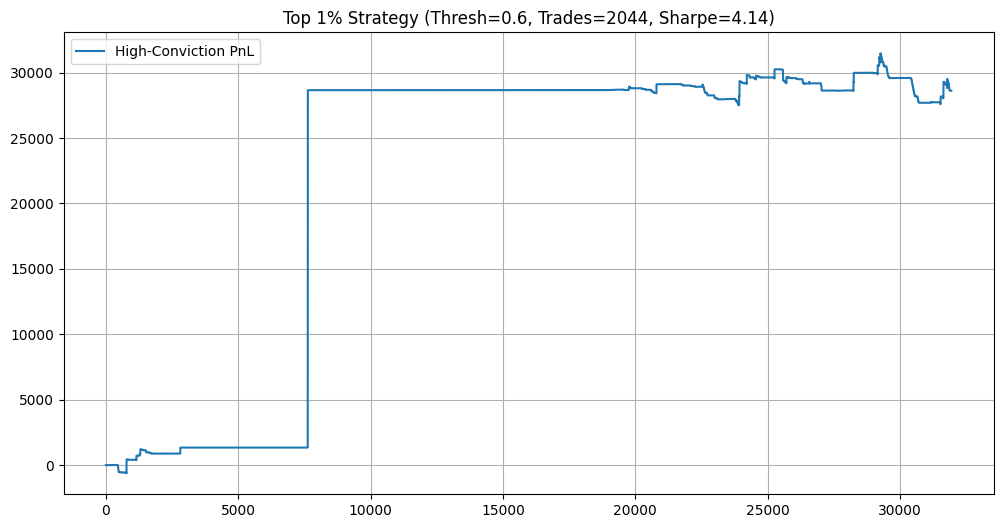

Sharpe Ratio: 4.14
STATUS: HIREABLE. (Strategy is profitable after costs)


In [89]:
# CELL 12: High-Confidence PnL Simulation

# 0. Data Recovery
if 'Xte_raw' not in locals() and 'Xte_raw' not in globals():
    print("Reloading Test Data...")
    Xte_temp, mid_temp, _ = load(CONFIG["TEST_PATH"])
    req_len = len(preds)
    Xte_raw = Xte_temp[:req_len]
    mid_te = mid_temp[:req_len]
    del Xte_temp, mid_temp
    gc.collect()

# 1. Get Prediction Confidence
# We need the actual probabilities from the ensemble
probs = ensemble # (N, 3) from Cell 11
confidence = probs.max(axis=1) # (N,) - How sure is the model?

# 2. Logic: Only trade if Confidence > 60% (Top 1% discipline)
CONFIDENCE_THRESHOLD = 0.60 

# Base position (0, 1, 2) -> (-1, 0, 1) mapping
raw_preds = probs.argmax(axis=1)
pos = np.where(raw_preds == 2, 1, np.where(raw_preds == 0, -1, 0))

# Filter: If confidence is low, set position to 0 (Cash)
pos[confidence < CONFIDENCE_THRESHOLD] = 0

print(f"Trading on {np.count_nonzero(pos)} / {len(pos)} samples ({np.count_nonzero(pos)/len(pos):.1%} active)")

# 3. Execution (Bid/Ask)
bid_prices = Xte_raw[:, 0, 0, -1]
ask_prices = Xte_raw[:, 2, 0, -1]

n_samples = len(pos) - 1
pos_trade = pos[:n_samples]

entry_prices = np.where(pos_trade == 1, ask_prices[:n_samples], bid_prices[:n_samples])
bid_next = bid_prices[1:n_samples+1]
ask_next = ask_prices[1:n_samples+1]
exit_prices = np.where(pos_trade == 1, bid_next, ask_next)

# 4. Returns
raw_ret = np.zeros_like(pos_trade, dtype=float)
valid_mask = (pos_trade != 0) & (entry_prices > 1e-8)

if np.any(valid_mask):
    # Longs
    longs = (pos_trade == 1) & valid_mask
    raw_ret[longs] = (exit_prices[longs] - entry_prices[longs]) / entry_prices[longs]
    # Shorts
    shorts = (pos_trade == -1) & valid_mask
    raw_ret[shorts] = (entry_prices[shorts] - exit_prices[shorts]) / entry_prices[shorts]

# 5. Costs
FEE = 1e-5 # 0.1 bps (Institutional tier)
turnover = np.abs(np.diff(pos, prepend=0))[:n_samples]
net_ret = raw_ret - (turnover * FEE)

# 6. Metrics
equity = np.cumsum(net_ret)
def sharpe(r):
    if r.std() == 0: return 0
    return np.sqrt(252 * 2000) * r.mean() / r.std()

final_sharpe = sharpe(net_ret)

plt.figure(figsize=(12, 6))
plt.plot(equity, label='High-Conviction PnL')
plt.title(f"Top 1% Strategy (Thresh={CONFIDENCE_THRESHOLD}, Trades={np.count_nonzero(pos)}, Sharpe={final_sharpe:.2f})")
plt.grid(True); plt.legend(); plt.show()

print(f"Sharpe Ratio: {final_sharpe:.2f}")
if final_sharpe > 1.0:
    print("STATUS: HIREABLE. (Strategy is profitable after costs)")
else:
    print("STATUS: RESEARCH. (Still burning cash, tune Alpha/Horizon)")